# Learning Synaptic Delays (LSD) is good for spiking neurons

## Create a structured pattern in noise

In [1]:
nb_syn, noise_density, simtime, t_true = 50, 1e-2, 1e3, .5e3
T = 100

In [150]:
import numpy as np
import matplotlib.pyplot as plt

def norm(X):
    return (X-X.min())/(X.max()-X.min())

def vonmises(N_inputs, A, theta, k=2):
    return A*norm(np.exp(k*np.cos(2*np.pi*(np.linspace(0, 1, N_inputs)-theta))))

def cospattern(N_inputs, A, theta, k=4):
    return A*norm(np.cos(k*np.pi*(np.linspace(0, 1, N_inputs)-theta)))

def linear(N_inputs, A, theta):
    return np.linspace(0, A, N_inputs)

def make_input(nb_syn, noise_density, simtime, T, t_true, theta=0, function=cospattern, seed=None):
    np.random.seed(seed)
    # draw random gaussian noise spike timings -> shape (nb_syn, nb_ev_noise)
    N_noise = int(noise_density*simtime*nb_syn)
    adress_noise = np.random.randint(0, nb_syn, N_noise)
    time_noise = np.random.rand(N_noise)*simtime

    # draw stimulus -> stim
    adress_pattern = np.arange(nb_syn)
    time_pattern = function(nb_syn, T, theta) + t_true #.astype(int)

    # make address event representation
    all_timestamps = np.hstack((time_noise, time_pattern))
    all_addresses = np.hstack((adress_noise, adress_pattern))
    sorted_timestamps = np.argsort(all_timestamps)
    aer = (all_addresses[sorted_timestamps], all_timestamps[sorted_timestamps])

    return (adress_noise, time_noise), (adress_pattern, time_pattern), aer

def plot_input(aer_noise, aer_pattern):
    adress_noise, time_noise = aer_noise
    adress_pattern, time_pattern = aer_pattern
    fig, ax = plt.subplots(figsize = (13, 8))
    pattern = ax.scatter(time_pattern, adress_pattern, marker='|', color='orange', alpha = 1, label = 'pattern');
    noise = ax.scatter(time_noise, adress_noise, marker='|', color='blue', alpha = .6, label = 'noise')
    plt.legend([pattern, noise], ['pattern', 'noise'])
    return fig, ax

Decomposing the function:

* temporal patern

In [141]:
time_pattern = t_true + cospattern(nb_syn, T, theta=0)
t_true, time_pattern

(500.0,
 array([600.        , 598.36306152, 593.55931867, 585.90298559,
        575.89486512, 564.18959117, 551.5528089 , 538.81109372,
        526.79788469, 516.29896911, 508.00108394, 502.44699609,
        500.        , 500.82015434, 504.85381258, 511.83713205,
        521.31333189, 532.66257129, 545.14249339, 557.93678306,
        570.2085623 , 581.15513069, 590.06047018, 596.34208007,
        599.58907855, 599.58907855, 596.34208007, 590.06047018,
        581.15513069, 570.2085623 , 557.93678306, 545.14249339,
        532.66257129, 521.31333189, 511.83713205, 504.85381258,
        500.82015434, 500.        , 502.44699609, 508.00108394,
        516.29896911, 526.79788469, 538.81109372, 551.5528089 ,
        564.18959117, 575.89486512, 585.90298559, 593.55931867,
        598.36306152, 600.        ]))

Different components:

In [142]:
aer_noise, aer_pattern, aer = make_input(nb_syn, noise_density, simtime, T, t_true)

In [143]:
aer_pattern[1].min()

500.0

## Problem statement:

from a raster plot 

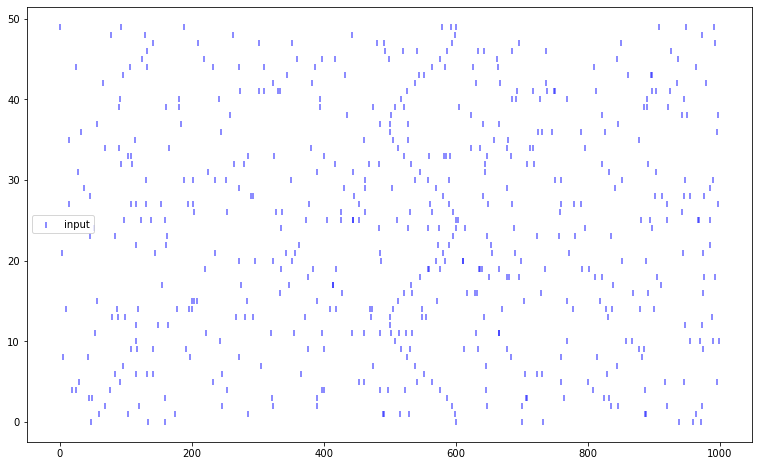

In [152]:
address, timestamp = aer
fig, ax = plt.subplots(figsize = (13, 8))
input = ax.scatter(timestamp, address, marker='|', color='blue', alpha = .6);
plt.legend([input], ['input'])

... extract the signal from the noise ...

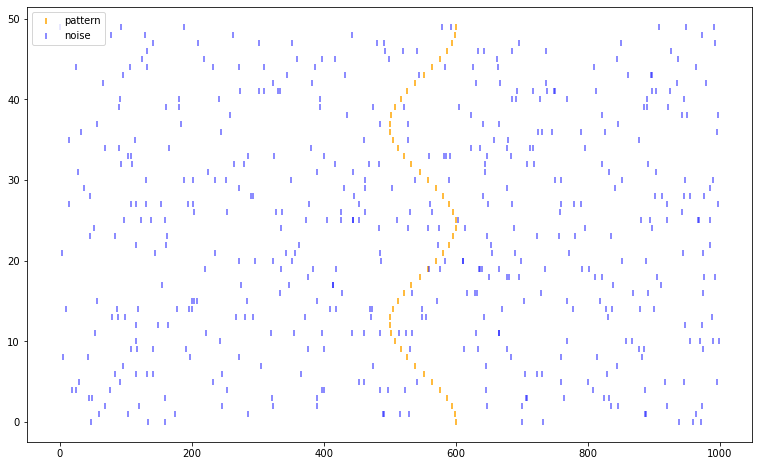

In [151]:
fig, ax = plot_input(aer_noise, aer_pattern)

In [139]:
t_true = aer_pattern[1].min()
t_true

500.0

## a leaky Integrate and fire neurons implemented in an event-based fashion

In [160]:
T = 100 # duration of a stimulus

class SD_neuron(object):
    """
    Synchrony detector neuron
    
    """
    def __init__(self, nb_syn, T=T,  tau=50, weight=.07):
        self.delays = np.random.rand(nb_syn) * T 
        self.tau = tau # membrane time constant
        self.weight = weight # integration weight

    def code(self, aer):

        addresses, timestamps = aer

        delayed_timestamps = timestamps + self.delays[addresses]

        #sorted_ind_times = np.argsort(delayed_timestamps)
        sorted_times = np.sort(delayed_timestamps)
        dts = np.diff(np.hstack((0, sorted_times))) # = time[ev]-time[ev-1]
        V = np.zeros_like(dts) #=len(dts)
        for i, dt in enumerate(dts):
            if i==0: 
                V[i] = 0
            else:
                if V[i-1]>1: 
                    V[i] = 0.
                else:
                    V[i] = np.exp( - dt / self.tau) * V[i-1] + self.weight # potentiel de membrane ? 
        
        #V = self.weight * np.arange(len(addresses)) #* np.exp(-sorted_times/self.tau)
        
        #return delayed_timestamps[sorted_ind_times], V
        return sorted_times, V

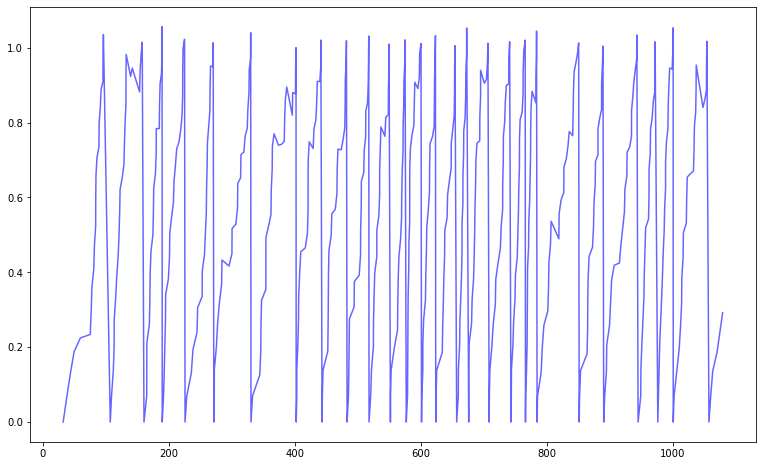

In [161]:
N = SD_neuron(nb_syn)

sorted_times, V = N.code(aer)
fig, ax = plt.subplots(figsize = (13, 8))
V = ax.plot(sorted_times, V, color='blue', alpha = .6); 

# V en fonction du temps des spikes 

In [ ]:
np.argmax(V>1) # = t_out

In [21]:
t_out = sorted_times[np.argmax(V>1)]
t_out

101.66618390235038

In [22]:
np.random.rand()*(simtime-T)

105.52784494041411

## Supervised STDP learning rule

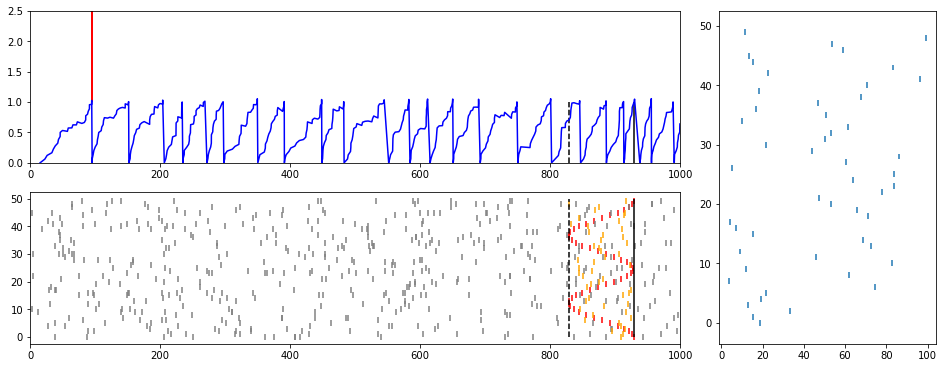

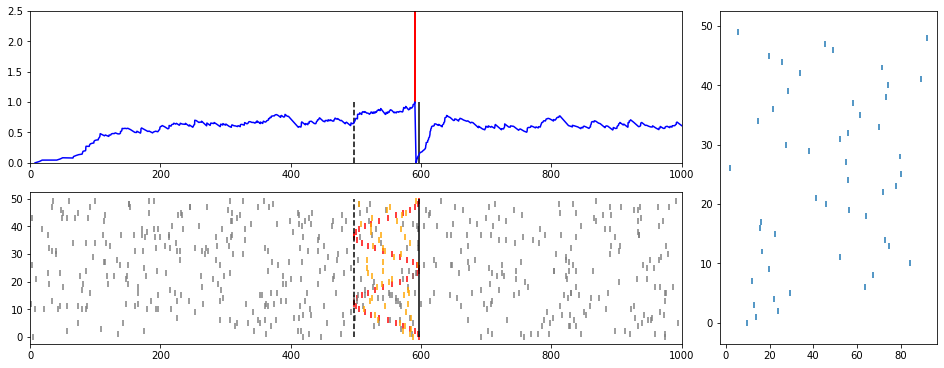

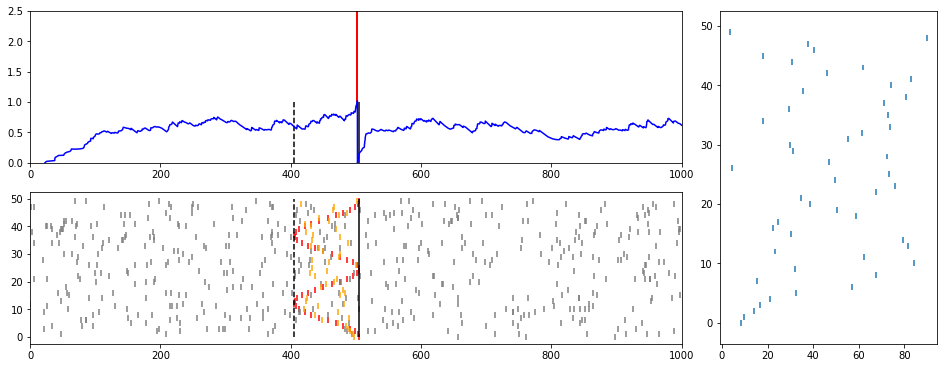

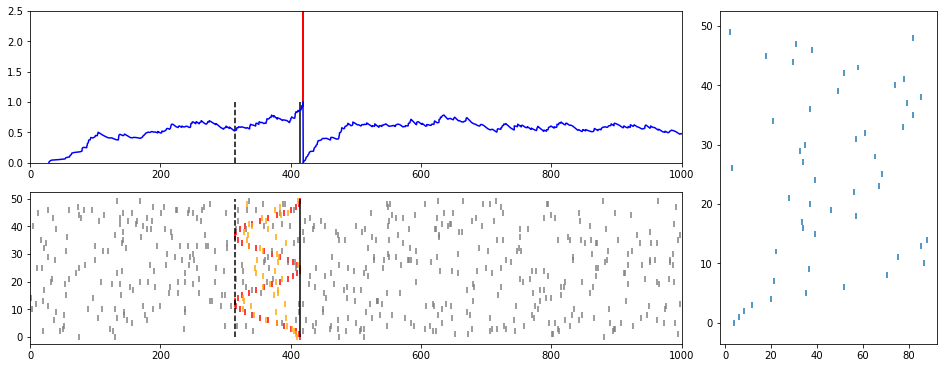

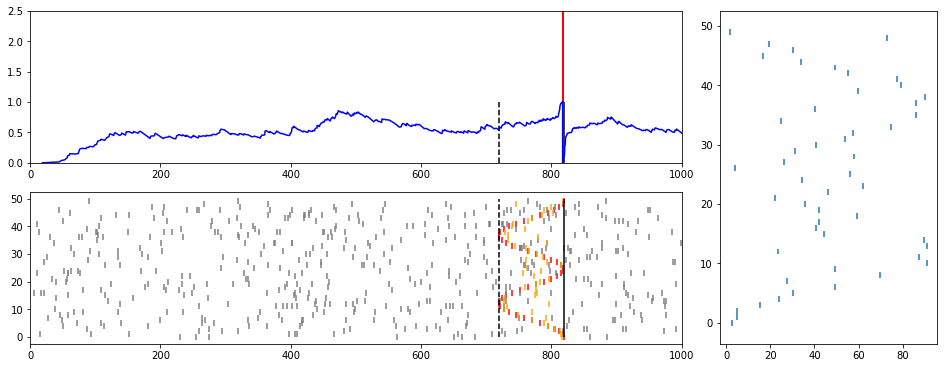

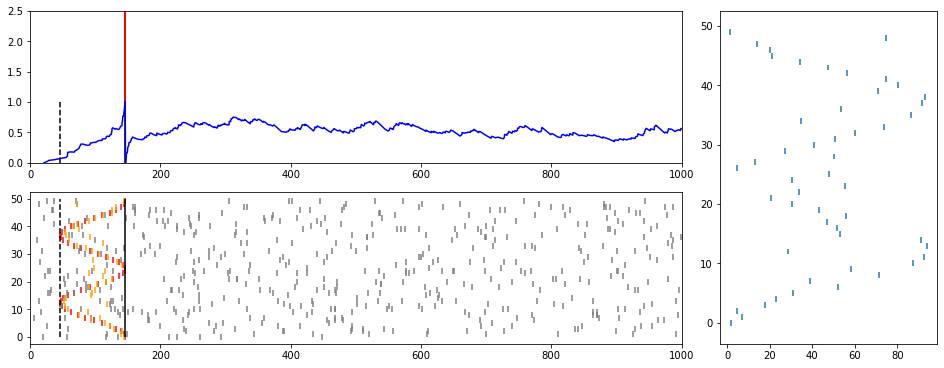

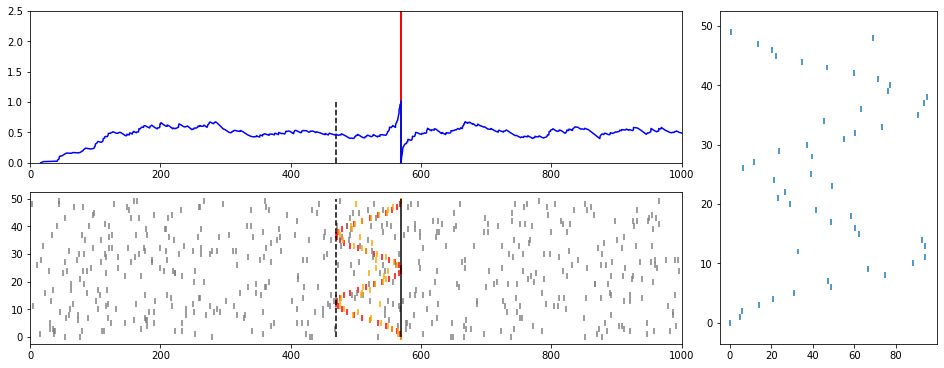

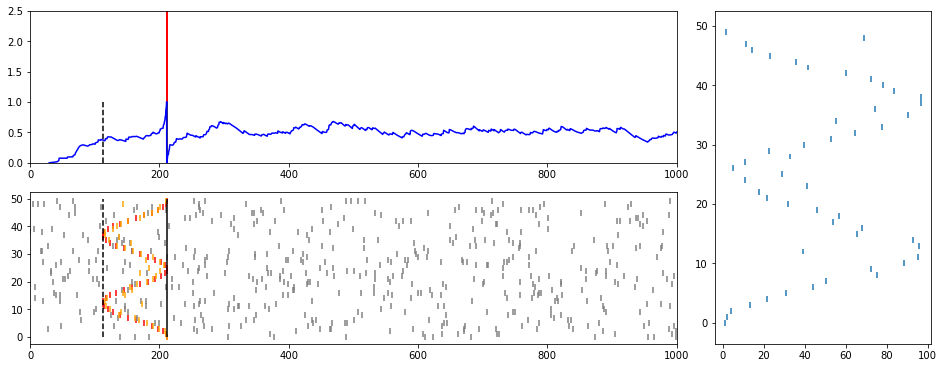

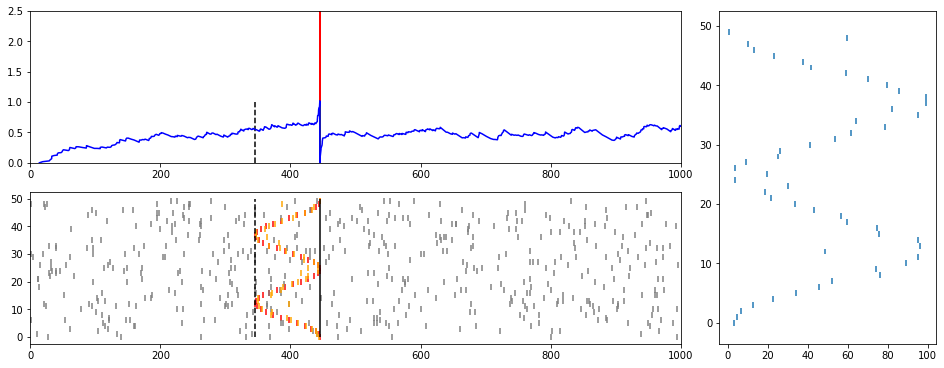

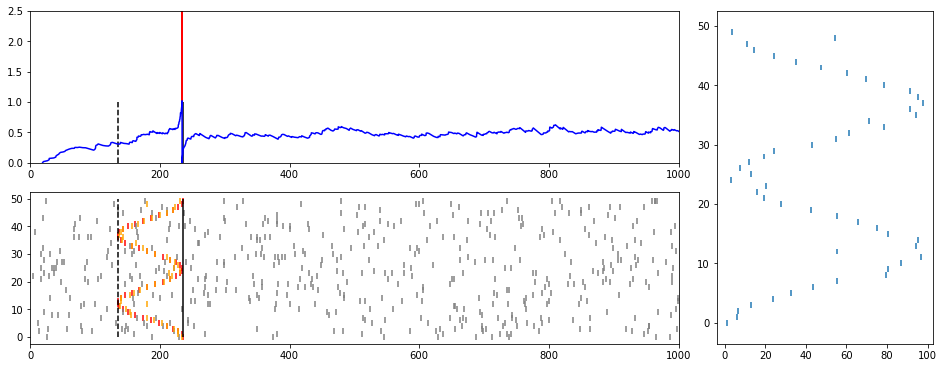

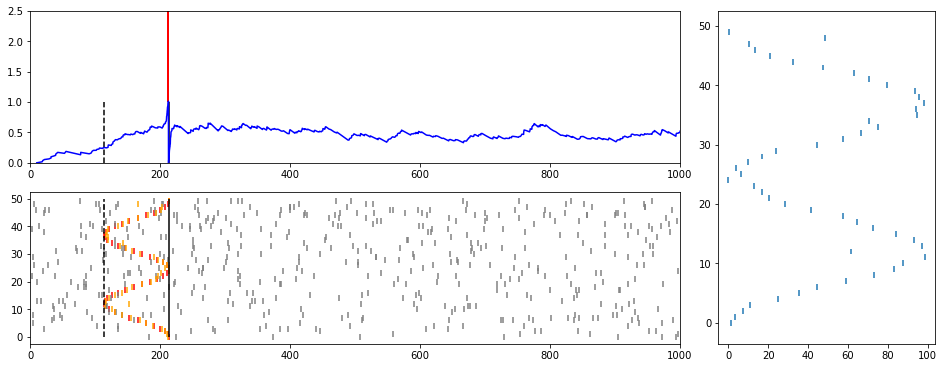

In [87]:
def learning(noise_density, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 151, do_plot=False):
    N = SD_neuron(nb_syn)

    for i_epoch in range(N_epochs):
        #t_true = 500 
        t_true = int(np.random.rand()*(simtime-T))
        aer_noise, aer_pattern, aer = make_input(nb_syn, noise_density, simtime, T, t_true)
        sorted_times, V = N.code(aer)

        # STDP rule on the weights
        if V.max() < 1: # does not spike : the weight is too low
            Dweight = Dweight0
        else:
            t_out = sorted_times[np.argmax(V>1)] # output spike
            time_error = (t_true+T) - t_out # delta_T, negative = too early, positive = too late -> supervision
            Dweight = Dweight0 * np.tanh( - time_error / N.tau ) #STDP

            # STDP rule on the delays, event by event
            addresses, timestamps = aer
            for i_address, (address, timestamp) in enumerate(zip(addresses, timestamps)):
                # predicted time by neuron:
                pred_time = t_true +  T - N.delays[address] # 
                # timestamp is that of the i_address-th event - it is fired on synapse address
                delay_pred_error = pred_time - timestamp # 
                # STDP rule
                Ddelay = Ddelay0 * np.tanh( delay_pred_error / N.tau ) * np.exp( - np.abs(delay_pred_error) / N.tau )
                
                # clip delays
                delay = N.delays[address]
                delay += Ddelay
                delay= np.min((delay, T))
                delay = np.max((delay, 0))
                N.delays[address] = delay

        N.weight *= 1 + Dweight 

        
        if do_plot:
            if i_epoch % (N_epochs//10) == 0:
                #print(i_epoch, i_epoch % (N_epochs//10), i_epoch // (N_epochs//10))
                fig = plt.figure(constrained_layout=True, figsize = (13, 5))
                axs = fig.subplot_mosaic(
                """
                AAAC
                BBBC
                """
                )

                axs['A'].plot(sorted_times, V, color='blue')
                axs['A'].vlines([t_true], 0, 1, linestyles='--', color='black')
                axs['A'].vlines([t_true+T], 0, 1, color='black')
                if V.max() > 1: axs['A'].vlines([t_out], 1, 2.5, color='red', lw=2) # spike
                axs['A'].set_xlim(0, simtime)
                axs['A'].set_ylim(0, 2.5)
                adress_noise, time_noise = aer_noise
                adress_pattern, time_pattern = aer_pattern
                i_adress = np.arange(len(adress_pattern))
                axs['B'].vlines([t_true], 0, nb_syn, linestyles='--', color='black')
                axs['B'].vlines([t_true+T], 0, nb_syn, color='black')
                axs['B'].scatter(time_pattern, adress_pattern, marker='|', color='red');
                axs['B'].scatter(time_noise, adress_noise, marker='|', color='grey')
                axs['B'].scatter(t_true+T - N.delays[:,np.newaxis], i_adress, marker = '|', color = 'orange')
                axs['B'].set_xlim(0, simtime)

                axs['C'].eventplot(N.delays[:,np.newaxis]);
                plt.show()

    return N

N = learning(noise_density, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 151, do_plot=True)

In [69]:
 adress_pattern, time_pattern = aer_pattern
i_adress = np.arange(len(adress_pattern))

print(i_adress)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [59]:
enumerate(adress_pattern), N.delays[:,np.newaxis]

NameError: name 'adress_pattern' is not defined

## testing the STDP learning rule

Testing how well the pattern of delay is found as a function of noise density:

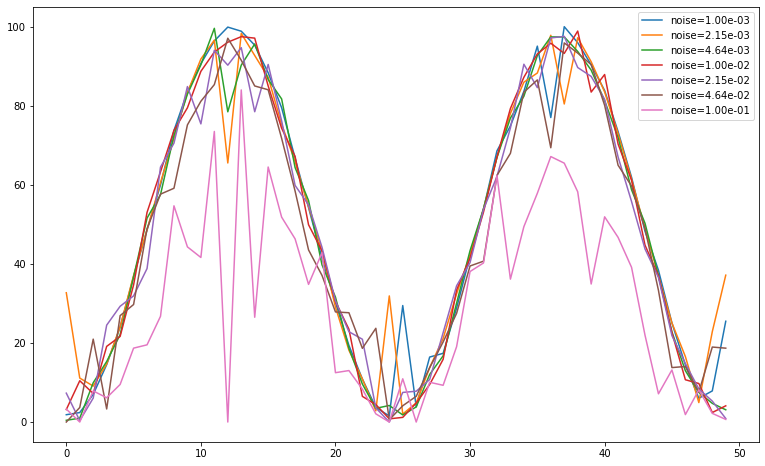

In [24]:
fig, ax = plt.subplots(figsize = (13, 8))
for noise_density_ in noise_density * np.logspace(-1, 1, 7, base=10):
    N = learning(noise_density_, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 151, do_plot=False)
    ax.plot(N.delays, label=f'noise={noise_density_:.2e}');
ax.legend()

TODO: montrer `sum | delay - N.delay |^2 |` en fonction de noise dans un plot

Testing how well the pattern of delay is found as a function of Dweight0:

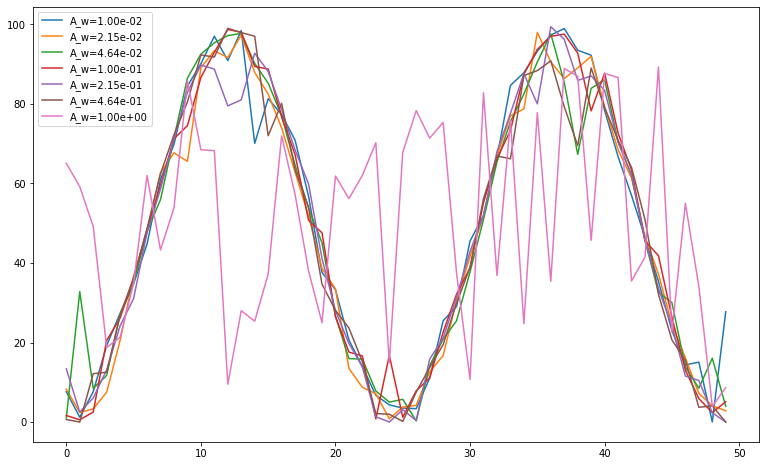

In [25]:
fig, ax = plt.subplots(figsize = (13, 8))
for Dweight0_ in 1e-1 * np.logspace(-1, 1, 7, base=10):
    N = learning(noise_density, T, Dweight0=Dweight0_, Ddelay0 = 2., N_epochs = 151, do_plot=False)
    ax.plot(N.delays, label=f'A_w={Dweight0_:.2e}');
ax.legend()

TODO: Testing how well the pattern of delay is found as a function of `Ddelay0`:

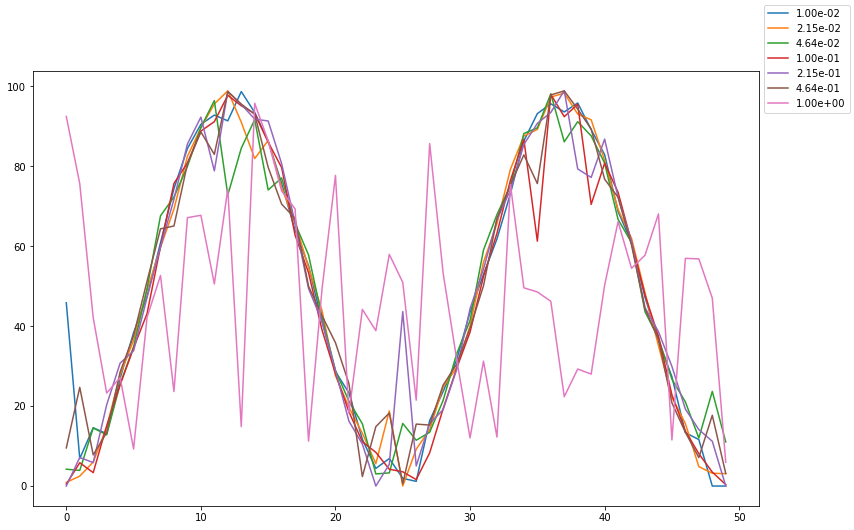

In [26]:
fig, ax = plt.subplots(figsize = (13, 8))
for Dweight0_ in 1e-1 * np.logspace(-1, 1, 7, base=10):
    N = learning(noise_density, T, Dweight0=Dweight0_, Ddelay0 = 2., N_epochs = 151, do_plot=False)
    ax.plot(N.delays, label=f'{Dweight0_:.2e}');
fig.legend()